## Metroid Google Maps
An interpretation of google maps for Super Metroid

In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
import sys
sys.path.append("..")

In [12]:
from ipyleaflet import *
from ipywidgets import Layout

In [13]:
import clingo

In [15]:
from encoding.parse_rooms import parse_rooms, parse_exits, dictify_rooms

## Set up ASP Solver

In [16]:
rooms = parse_rooms("../encoding/dsl/rooms_for_alloy.txt")
exits = parse_exits("../encoding/dsl/exits_for_alloy.txt")
design = dictify_rooms(rooms, exits)

In [17]:
def symbol(**kwargs):
  assert len(kwargs) == 1
  for tag, ident in kwargs.items(): 
    prefix = ""#tag + "_"
    return prefix + re.sub('[^_a-z0-9]','',ident.lower())

condition_ids = {}

with open('../output/metroidIII.lp', 'w') as f:

  for item_name, item_description in design['Items'].items():
    f.write(f"item({symbol(item=item_name)}).\n")

  for boss_name, boss_description in design['Bosses'].items():
    f.write(f"boss({symbol(item=boss_name)}).\n")

  for room_name, room in design['Rooms'].items():
    f.write(f"room({symbol(room=room_name)}).\n")

    for node_name in room['Nodes']:
      f.write(f"node({symbol(room=room_name)},{symbol(node=node_name)}).\n")

    for node_name, item_name in room['Drops'].items():
      f.write(f"drops({symbol(room=room_name)},{symbol(node=node_name)},{symbol(item=item_name)}).\n")

    for src_node, dst_spec in room['Doors'].items():
      dst_room = dst_spec['Room']
      dst_node = dst_spec['Node']
      f.write(f"door({symbol(room=room_name)},{symbol(node=src_node)},{symbol(room=dst_room)},{symbol(node=dst_node)}).\n")

    for src_node, edges in room['Edges'].items():
      for dst_spec in edges:
        dst_node = dst_spec['Terminal']
        f.write(f"edge({symbol(room=room_name)},{symbol(node=src_node)},{symbol(node=dst_node)}).\n")  
        for i, requirements in enumerate(dst_spec['Requirements']):
          requirements_tuple = tuple(requirements)
          if requirements_tuple not in condition_ids:
            n = len(condition_ids)
            f.write(f"condition({n}).\n")
            for item in requirements:
              f.write(f"condition_requires({n},{symbol(item=item)}).\n")
            condition_ids[requirements_tuple] = n
          n = condition_ids[requirements_tuple]
          f.write(f"edge_condition({symbol(room=room_name)},{symbol(node=src_node)},{symbol(node=dst_node)},{n}).\n")

!cat ../output/metroidIII.lp | sort | cut -f 1 -d'(' | uniq -c | sort -nr

   2447 edge_condition
   1019 edge
    777 condition_requires
    697 node
    584 door
    523 edge
    255 room
    254 condition
    112 drops
     25 item
     10 boss


In [18]:
# Set up control with the objects
ctl = clingo.Control([], logger=print)
with open('../output/metroidIII.lp', 'r') as f:
  metroid3_s = "\n".join(f.readlines())
ctl.add("metroid3", [], metroid3_s)

In [19]:
%%file ../output/path.lp

#const t_max = 25.
time(0..t_max).

% Within room
nav_edge(R, N1, R, N2) :- edge(R, N1, N2).
% Between room
nav_edge(R1, N1, R2, N2) :- door(R1, N1, R2, N2).

% Policy gives up to one outgoing location for each (reachable) node at each time step
{ policy(T, R1, N1, R2, N2):nav_edge(R1, N1, R2, N2) } 1 :- time(T), node(R1, N1).
%{ policy(T, R1, N1, R2, N2):nav_edge(R1, N1, R2, N2) } 1 :- time(T), node(R1, N1), reach(T, R1, N1).

satisfied(T,C) :- time(T), condition(C), has(T,I):condition_requires(C,I).

has(T,I) :- time(T), has(T-1,I).
has(T,I) :- step(T,R,N), drops(R,N,I).

reach(T,R,N) :- step(T,R,N).
reach(T,R,N2) :- reach(T,R,N1), edge_condition(R,N1,N2,C), satisfied(T,C), policy(T, R, N1, R, N2).
reach(T,R2,N2) :- reach(T,R1,N1), door(R1,N1,R2,N2), policy(T, R1, N1, R2, N2).

{ step(T+1,R,N) } :- time(T), reach(T,R,N), drops(R,N,I), not has(T,I).
:- time(T), 2 { step(T,R,N) }.

Writing ../output/path.lp


In [20]:
# Set up control with the path constraints
with open('../output/path.lp', 'r') as f:
  path_s = "\n".join(f.readlines())
ctl.add("path", [], path_s)

In [22]:
from bidict import bidict

In [23]:
# Maps the "common" name of a node to the name that ASP will use (and vice versa)
room_name_mapping = bidict({})
for room_name, room in design["Rooms"].items():
  for node_name in room["Nodes"]:
    node_full_name = f"{room_name}_{node_name}"
    node_asp_name = (symbol(room=room_name), symbol(node=node_name))
    room_name_mapping[node_full_name] = node_asp_name

In [24]:
from data_types.item_set import ItemSet

In [25]:
# Set up control with the actual problem
#TODO: do this with a Context
def mk_conditions(start_position, start_item_set, end_position, end_item_set):
  # Start conditions
  r, n = room_name_mapping[start_position]
  start_pos = [f"step(0, {r}, {n})."]
  i_names = [symbol(item=i) for i in start_item_set]
  start_items = [f"(has(0,{i})." for i in i_names]
  start_constraint = "\n".join(start_items + ["has(0, start)."] + start_pos)
  # End conditions
  i_names = [symbol(item=i) for i in end_item_set]
  end_items = [f"has(T,{i})" for i in i_names]
  r, n = room_name_mapping[end_position]
  end_pos = [f"reach(T, {r}, {n})"]
  end_constraint = ", ".join(end_items + end_pos)
  end_constraint = f"goal(T) :- {end_constraint}.\ngoal :- goal(T).\n:- not goal."
  return start_constraint + "\n" + end_constraint
print(mk_conditions("Landing_Site_Ship", ItemSet([]), "Landing_Site_Ship", ItemSet(["Mother_Brain"])))

has(0, start).
step(0, landing_site, ship).
goal(T) :- has(T,mother_brain), reach(T, landing_site, ship).
goal :- goal(T).
:- not goal.


In [26]:
ctl.add("initial", [], mk_conditions("Landing_Site_Ship", ItemSet([]), "Landing_Site_Ship", ItemSet(["Mother_Brain"])))
# For some reason, this bottom thing fails to parse...
#ctl.add("initial", [], """\
#reach(0,R,N) :- @starting_pos(R, N).
#has(0,I) :- @starting_items(I).
#goal(T) :- reach(T, R, N), @ending_pos(R, N), { has(T, I): @ending_items(I) }.
#goal :- goal(T).
#:- not goal.""")

In [27]:
import networkx as nx

In [52]:
def parse_policy(p, g):
  t, r1, n1, r2, n2 = p.arguments
  #print(int(t), r1, n1, r2, n2)
  t = t.number
  node1 = (t, r1.name, n1.name)
  node2 = (t, r2.name, n2.name)
  g.add_edge(node1, node2)

def parse_step(s, g):
  t, r, n = s.arguments
  t = t.number
  print(s)
  node1 = (t-1, r.name, n.name)
  node2 = (t, r.name, n.name)
  g.add_edge(node1, node2)

class Context(object):

  def __init__(self, start_pos, start_itemset, end_pos, end_itemset):
    # Start
    self.start_pos = start_pos
    r, n = room_name_mapping[start_pos]
    self.asp_start_pos = (clingo.Symbol(r), clingo.Symbol(n))
    self.start_itemset = start_itemset
    self.asp_start_itemset = [clingo.Symbol(symbol(item=i)) for i in start_itemset]
    # End
    self.end_pos = end_pos
    r, n = room_name_mapping[end_pos]
    self.asp_end_pos = (clingo.Symbol(r), clingo.Symbol(n))
    self.end_itemset = end_itemset
    self.asp_end_itemset = [clingo.Symbol(symbol(item=i)) for i in end_itemset]
    # Other
    self.graph = None

  # Only need one path
  def on_model(self, model):
    g = nx.Graph()
    for s in model.symbols(shown=True):
      if s.name == "policy":
        parse_policy(s, g)
      if s.name == "step":
        parse_step(s, g)
    self.graph = g

  def starting_position(self, r, n):
    return self.asp_start_pos

  def ending_position(self, r, n):
    return self.asp_end_pos

  def starting_item(self, i):
    return [clingo.Symbol(i) for i in self.asp_start_itemset]
  
  def ending_item(self, i):
    return [clingo.Symbol(i) for i in self.asp_end_itemset]

  def get_end_t(self):
    assert self.graph is not None
    ends = [n for n in self.graph.nodes if n[1:] == room_name_mapping[self.end_pos]]
    # Node with the max step is the last time we visit this node
    m = max(ends, key=lambda n: n[0])
    return m

  def get_path(self):
    assert self.graph is not None
    start = (0, *room_name_mapping[self.start_pos])
    end = self.get_end_t()
    #print(start, end)
    path  = nx.shortest_path(self.graph, source=start, target=end)
    return path
    # Go back to "common" names
    #return [room_name_mapping.inverse[p[1:]] for p in path]

  def solve_path(self):
    # Set up control with the objects
    ctl = clingo.Control([], logger=print)
    with open('../output/metroidIII.lp', 'r') as f:
      metroid3_s = "\n".join(f.readlines())
    ctl.add("metroid3", [], metroid3_s)
    # Set up control with the path constraints
    with open('../output/path.lp', 'r') as f:
      path_s = "\n".join(f.readlines())
    ctl.add("path", [], path_s)
    ctl.add("initial", [], mk_conditions(self.start_pos, self.start_itemset, \
                                         self.end_pos, self.end_itemset))
    ctl.ground([("metroid3", []), ("path", []), ("initial", [])])#, context=self)
    ctl.solve(on_model=self.on_model)
    path = self.get_path()
    return path
    #return [room_name_mapping.inverse[p[1:]] for p in path]

In [53]:
ctx = Context("Landing_Site_Ship", ItemSet([]), "Landing_Site_Ship", ItemSet(["Mother_Brain"]))
#ctx = Context("Landing_Site_Ship", ItemSet([]), "Morph_Ball_Room_MB", ItemSet(["MB"]))
game_path = ctx.solve_path()
len(game_path)

step(0,landing_site,ship)
step(1,morph_ball_room,mb)
step(2,first_missile,m)
step(3,bomb_torizo,bombs)
step(4,big_pink,cb)
step(13,spore_spawn,spawn)
step(5,spore_spawn_supers,s)
step(12,spazer,spazer)
step(9,hi_jump,hj)
step(6,kraid,kraid)
step(7,varia_suit,v)
step(8,warehouse_energy,e)
step(15,speed_booster,sb)
step(10,wave_beam,wb)
step(17,brinstar_reserve,rt)
step(18,ice_beam,ib)
step(11,crocomire,crocomire)
step(14,postcroc_power_bombs,pb)
step(16,grapple,g)
step(19,phantoon,phantoon)
step(20,gravity,gs)
step(21,draygon,draygon)
step(22,space_jump,sj)
step(23,plasma,plb)
step(24,ridley,ridley)
step(25,mother_brain,brain)


931

In [66]:
# (room, node) -> item_name
drop_table = {}
for room_name, room in design['Rooms'].items():
    for node_name, item_name in room['Drops'].items():
        drop_table[(symbol(room=room_name), symbol(node=node_name))] = item_name

In [106]:
def get_intervals(path):
    intervals = []
    current_t = 0
    current_index = 0
    for (i, (t, r, n)) in enumerate(path):
        if t != current_t:
            intervals.append(((current_index, i), drop_table[(r, n)]))
            current_t = t
            current_index = i
    intervals.append(((current_index, i), "END"))
    return intervals

In [54]:
game_path_locs = [room_name_mapping.inverse[p[1:]] for p in game_path]

## Set up Super Metroid info

In [32]:
from world_rando.coord import Coord

In [33]:
# Room graphics and info

#$079F: Area index
#{
#    0: Crateria
#    1: Brinstar
#    2: Norfair
#    3: Wrecked Ship
#    4: Maridia
#    5: Tourian
#    6: Ceres
#    7: Debug
#}
# Units are Map Screens which are 16 x 16 tiles
area_offsets = {
    0: Coord(3, 10),
    1: Coord(0, 29),
    2: Coord(31, 49),
    #2: (31, 61),
    #3: (40, 0),
    3: Coord(37, 0),
    #4: (29, 29),
    4: Coord(28, 29),
    5: Coord(0, 10),
    # Out of bounds
    6: Coord(0, -10),
    7: Coord(0, 0),
}

In [35]:
from rom_tools.rom_manager import RomManager

In [37]:
rom = RomManager("../../roms/sm_clean.sfc", "sm_junk.smc")

In [38]:
parsed = rom.parse()

In [39]:
from rom_tools import graphics
from world_rando import room_gen

In [40]:
def get_room_image(room_header):
  d = room_header.state_chooser.default
  tileset = d.tileset
  level_shape = d.level_data.level_array.layer1.shape
  level = room_gen.level_from_bytes(d.level_data.level_bytes, Coord(*level_shape))
  # Set up graphics stuff
  tileset_table = graphics.get_tileset_table(rom)
  uc_tile_table, uc_tile_sheet, uc_palette = graphics.get_tileset(rom, tileset, tileset_table)
  cre_tile_sheet = graphics.get_cre_tilesheet(rom)
  cre_tile_table = graphics.get_cre_tile_table(rom)
  sce_tiles = graphics.tile_images(uc_tile_table, uc_tile_sheet, cre_tile_sheet, uc_palette)
  cre_tiles = graphics.tile_images(cre_tile_table, uc_tile_sheet, cre_tile_sheet, uc_palette)
  return graphics.level_image(level, sce_tiles, cre_tiles)

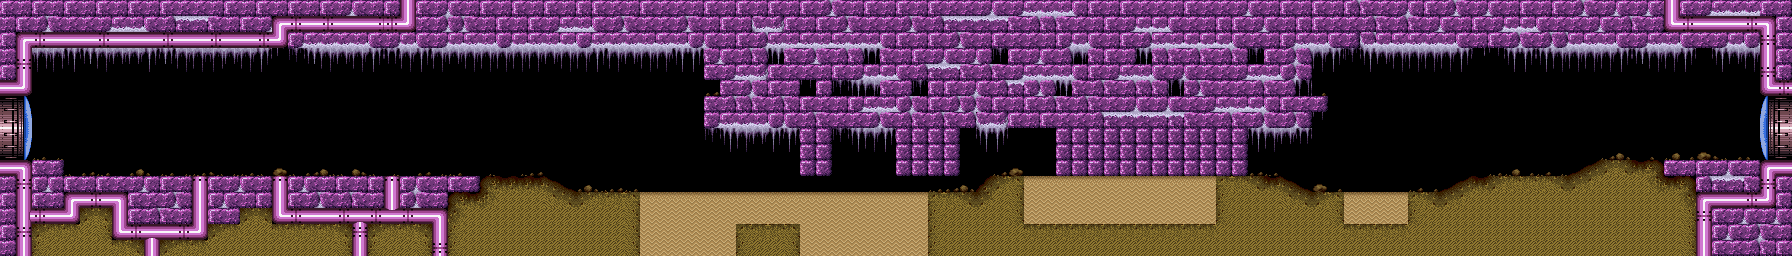

In [41]:
get_room_image(parsed["room_header_0x7d7e4"])

In [42]:
def get_room_header(room):
  try:
    return parsed[f"room_header_{hex(room.mem_address)}"]
  except KeyError:
    return None

#TODO: Temporary fix for uncommitted fixes
rooms["Brinstar_Refill"].mem_address = 0x7a07b
rooms["Maridia_Elevator"].mem_address = 0x7d30b

for room_name, room in rooms.items():
  #print(get_room_header(room))
  if get_room_header(room) is None:
    print(room.name)
    print(hex(room.mem_address))

# Get node locations

In [43]:
from collections import defaultdict
from world_rando.parse_rules import mk_plm_to_item
from rom_tools.item_definitions import make_item_definitions
from world_rando.parse_rules import get_item_locations # returns Coord -> ItemSet mapping

In [44]:
#TODO: temporary until push changes for sm_rando
def get_item_locations(plms):
  item_locations = {}
  plm_to_item = mk_plm_to_item(make_item_definitions())
  for plm in plms.l:
    if plm.plm_id in plm_to_item:
      iset = plm_to_item[plm.plm_id]
      c = Coord(plm.x_pos, plm.y_pos)
      item_locations[c] = iset
  return item_locations


In [45]:
def get_door_positions(level_arrays, ignore_locs):
  # Find the door positions
  doors = defaultdict(list)
  for i, j in np.ndenumerate(level_arrays.layer1):
    if i in ignore_locs:
      continue
    if j.tile_type == 9:
      door_id = level_arrays.bts[i]
      doors[door_id].append(Coord(*i))
  return doors

def get_door_averages(doors):
  # Find the door average position
  door_a = {}
  for i, cs in doors.items():
    cxa = sum([c.x for c in cs]) / len(cs)
    cxy = sum([c.y for c in cs]) / len(cs)
    c_a = Coord(cxa, cxy)
    door_a[i] = c_a
  return door_a

def get_door_directions(doors, door_a, level_arrays):
  sand_tindices = [280, 528, 640]
  # Find the direction for each door
  door_d = {}
  ls = []
  rs = []
  ts = []
  bs = []
  for d, a in door_a.items():
    #print(d, a)
    # Left door
    if a.x % 16 == 0:
      if len(doors[d]) == 1:
        door_d[d] = "LMB{}"
      else:
        door_d[d] = "L{}"
      ls.append(d)
    # Right door
    elif a.x % 16 == 15:
      if len(doors[d]) == 1:
        door_d[d] = "RMB{}"
      else:
        door_d[d] = "R{}"
      rs.append(d)
    # Top door
    elif a.y % 16 == 0:
      if level_arrays.layer1[doors[d][0]].texture.texture_index in sand_tindices:
        door_d[d] == "TS{}"
      elif len(doors[d]) == 2:
        door_d[d] = "EB{}"
      else:
        door_d[d] = "T{}"
      ts.append(d)
    # Bottom door
    elif a.y % 16 == 15:
      if level_arrays.layer1[doors[d][0]].texture.texture_index in sand_tindices:
        door_d[d] = "BS{}"
      elif len(doors[d]) == 2:
        door_d[d] = "ET{}"
      else:
        door_d[d] = "B{}"
      bs.append(d)
    else:
      # Elevator
      if len(doors[d]) == 2:
        pass
      else:
        assert False, f"No direction found for door {d}!"
  return (ls, rs, ts, bs), door_d

def compute_name_positions(door_lists, doors, door_a, door_d):
  # Sort everything and compute positions
  ls, rs, ts, bs = door_lists
  ls = sorted(ls, key = lambda d: door_a[d].y)
  rs = sorted(rs, key = lambda d: door_a[d].y)
  ts = sorted(ts, key = lambda d: door_a[d].x)
  bs = sorted(bs, key = lambda d: door_a[d].x)
  name_posns = {}
  def convert_names(ls):
    for i,l in enumerate(ls):
      f = i + 1
      if len(ls) == 1:
        f = ""
      name_posns[door_d[l].format(f)] = door_a[l]
  convert_names(ls)
  convert_names(rs)
  convert_names(ts)
  convert_names(bs)
  return name_posns

def get_all_item_positions(room_header):
  item_posns = {}
  for rs in [x.state for x in room_header.state_chooser.conditions] + [room_header.state_chooser.default]:
    d = get_item_locations(rs.plms)
    item_posns.update(d)
  return item_posns

def get_item_names(item_positions):
  item_d = defaultdict(list)
  for k, v in item_positions.items():
    assert len(v) == 1
    item_str = item_str = v.to_list()[0]
    item_d[item_str].append(k)
  item_names = {}
  for i, posns in item_d.items():
    if len(posns) == 1:
      item_names[i] = posns[0]
    else:
      #TODO: these may not actually refer to the same item!
      # But there are very few rooms with the same type of item twice...
      for j, p in enumerate(sorted(posns)):
        item_names[f"{i}{j+1}"] = p
  return item_names

#TODO items
def get_global_locations(room, ignore_locs=[]):
  room_header = parsed[f"room_header_{hex(room.mem_address)}"]
  area_pos = area_offsets[room_header.area_index]
  room_map_pos = Coord(room_header.map_x, room_header.map_y)
  #print(area_pos, room_map_pos)
  global_offset = (area_pos + room_map_pos).scale(16)
  global_name_posns = {}
  # PLMs
  item_d = get_all_item_positions(room_header)
  item_names = get_item_names(item_d)
  for k,v in item_names.items():
    global_name_posns[f"{room.name}_{k}"] = v + global_offset
  # Doors
  level_arrays = room_header.state_chooser.default.level_data.level_array
  doors = get_door_positions(level_arrays, ignore_locs)
  door_a = get_door_averages(doors)
  #print(doors)
  #print(door_a)
  door_lists, door_d = get_door_directions(doors, door_a, level_arrays)
  door_posns = compute_name_positions(door_lists, doors, door_a, door_d)
  global_door_posns = {f"{room.name}_{k}": v + global_offset for k,v in door_posns.items()}
  global_name_posns.update(global_door_posns)
  return global_name_posns

In [46]:
get_global_locations(rooms["Mount_Everest"], ignore_locs=[(15, 41), (86,32), (87,32), (88,32), (89,32)])

{'Mount_Everest_L1': c(640.0,615.5),
 'Mount_Everest_LMB2': c(656.0,649.0),
 'Mount_Everest_R': c(735.0,615.5),
 'Mount_Everest_T': c(679.5,608.0),
 'Mount_Everest_B1': c(663.5,671.0),
 'Mount_Everest_B2': c(711.5,671.0)}

In [47]:
ignore_locs = {
    "West_Ocean": [(48,38), (48,39), (48,40), (48,41), (80,38), (80,39), (80,40), (80,41),
                   (79,38), (79,39), (79,40), (79,41), (95,38), (95,39), (95,40), (95,41)],
    "Mount_Everest": [(15, 41),
                      (86,32), (87,32), (88,32), (89,32)],
    "Plasma_Spark": [(0,41), (48,22), (48,23), (48,24), (48,25)],
    "Pseudo_Plasma_Spark": [(63, 9)]
}

In [48]:
lll = parsed["room_header_0x7d898"].state_chooser.default.level_data.level_array.layer1
lll[(7, 15)].texture

(640, 0, 0)

In [49]:
all_global_positions = {}
for room_name, r in rooms.items():
  if room_name in ignore_locs:
    i = ignore_locs[room_name]
  else:
    i = []
  d = get_global_locations(r, i)
  all_global_positions.update(d)
  gp_nodes = set(d.keys())
  r_nodes = set(r.graph.nodes)
  if gp_nodes != r_nodes:
    print(room_name, hex(r.mem_address))
    print(f"\t Extra: {list(gp_nodes - r_nodes)}")
    print(f"\t Missing: {list(r_nodes - gp_nodes)}")
# TS will be missing
# Bombs will be missing - Bombs / B error again
# Boss nodes will be missing
# Mother Brain L
# Outside of this - Parsing errors:
# West_Ocean
# R4 -> R6 and L -> L2

Landing_Site 0x791f8
	 Extra: []
	 Missing: ['Landing_Site_Ship']
West_Ocean 0x793fe
	 Extra: ['West_Ocean_L', 'West_Ocean_R4']
	 Missing: ['West_Ocean_R6', 'West_Ocean_L2']
Bomb_Torizo 0x79804
	 Extra: ['Bomb_Torizo_B']
	 Missing: ['Bomb_Torizo_Bombs']
Spore_Spawn 0x79dc7
	 Extra: []
	 Missing: ['Spore_Spawn_Spore_Spawn']
Kraid 0x7a59f
	 Extra: []
	 Missing: ['Kraid_Kraid']
Statues 0x7a66a
	 Extra: []
	 Missing: ['Statues_Statues']
Crocomire 0x7a98d
	 Extra: []
	 Missing: ['Crocomire_Crocomire']
Water_Closet 0x7b1e5
	 Extra: []
	 Missing: ['Water_Closet_Drain']
Golden_Torizo 0x7b283
	 Extra: []
	 Missing: ['Golden_Torizo_Golden_Torizo']
Ridley 0x7b32e
	 Extra: []
	 Missing: ['Ridley_Ridley']
Phantoon 0x7cd13
	 Extra: []
	 Missing: ['Phantoon_Phantoon']
West_Sand_Hall 0x7d461
	 Extra: []
	 Missing: ['West_Sand_Hall_TS']
East_Sand_Hall 0x7d4c2
	 Extra: []
	 Missing: ['East_Sand_Hall_TS']
West_Sand_Hole 0x7d4ef
	 Extra: []
	 Missing: ['West_Sand_Hole_TS']
East_Sand_Hole 0x7d51e
	 Extra: 

In [55]:
points = [all_global_positions[c] for c in game_path_locs if c in all_global_positions]
xs = [c.x for c in points]
ys = [c.y for c in points]

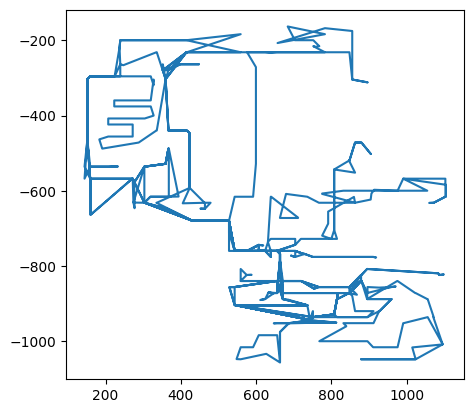

In [56]:
gca().set_aspect("equal")
plot(np.array(xs), -np.array(ys))

In [76]:
points2 = []
for c in game_path_locs:
    if c in all_global_positions:
        points2.append(all_global_positions[c])
    else:
        points2.append(None)

In [107]:
game_intervals = get_intervals(game_path)
pxs = []
pys = []
ilist = []
for ((start, end), item) in game_intervals:
    p2 = points2[start:end]
    p2x = [p.x for p in p2 if p is not None]
    p2y = [p.y for p in p2 if p is not None]
    ilist.append(item)
    pxs.append(p2x)
    pys.append(p2y)

In [108]:
colormaps["viridis"](1), colormaps["viridis"](256)

((0.26851, 0.009605, 0.335427, 1.0), (0.993248, 0.906157, 0.143936, 1.0))

In [109]:
game_intervals[-1]

((915, 930), 'END')

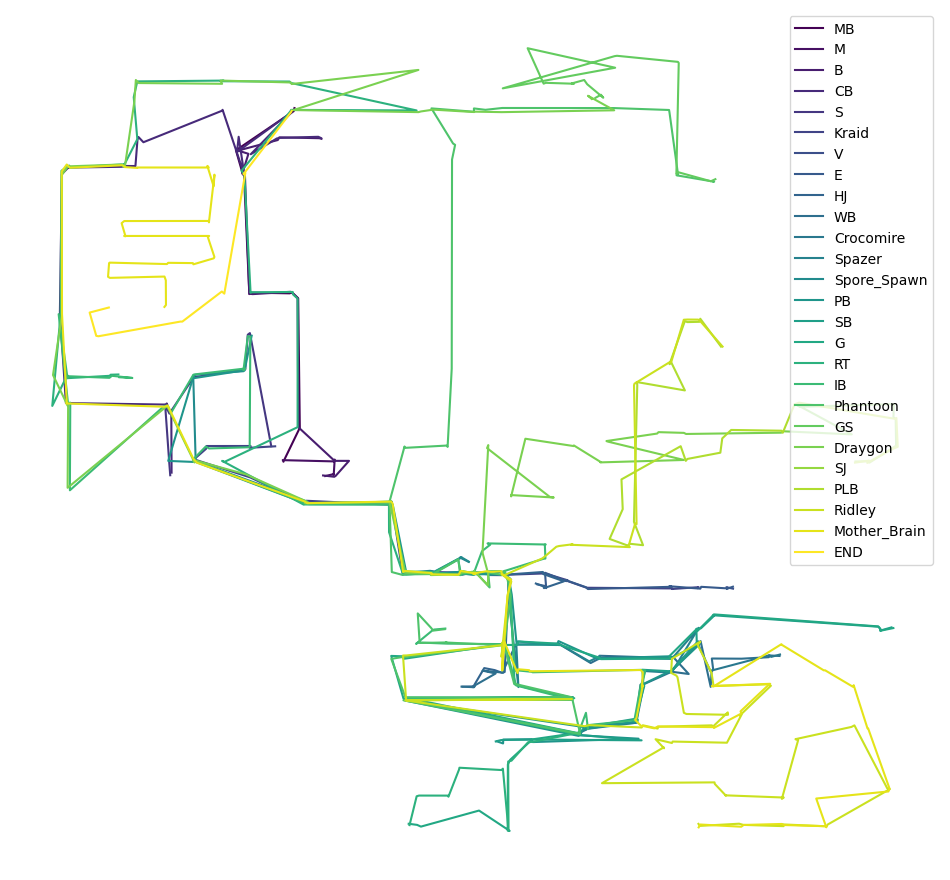

In [110]:
figsize(12, 12)
gca().set_aspect("equal")
c = np.linspace(0, 1, len(pxs))
colors = [colormaps["viridis"](i) for i in c]
for px, py, i, color in zip(pxs, pys, ilist, colors):
    rx = 5 * (0.5 - np.random.rand(len(px)))
    ry = 5 * (0.5 - np.random.rand(len(py)))
    plot(np.array(px) + rx, -np.array(py) + ry, label=i, color=color)
    #plot(np.array(px) + rx, -np.array(py) + ry, label=i)
    #TODO Jitter amount based on the hash of the itemset
axis("off")
legend()

## Set up Map

In [ ]:
location = ((0,0), (1,1))
m = Map(center=(0.5, 0.5), zoom=8, layout=Layout(width="500px", height="500px"))
m.clear_layers()
len(m.layers)
image = ImageOverlay(url="https://www.vgmaps.com/Atlas/SuperNES/SuperMetroid-Zebes(In-GameMap).png", bounds=location)
m.add_layer(image)
m.fit_bounds(location)

In [ ]:
m

In [ ]:
from ipywidgets import *

In [ ]:
w

In [ ]:
w.value="Goodbye"

In [ ]:
w2 = Label("Crateria")

In [ ]:
w2.value="Maridia"
w2

In [ ]:
w.on_submit(lambda x: print("submitted"))

In [ ]:
text_input = Text()
text_output = HTML("foo")
@text_input.on_submit
def text_input_callback(x):
  print(f"Submitted {x}")
  text_output.value=x.value
HBox([VBox([text_input, text_output]), m])

In [ ]:
# SelectMultiple for items